# FraudLearn
An Online Fraud Detection Algorithm using ML.   
The algorithms used here are XGBoost and Random Forest

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

The Dataset that we have taken is from Kaggle.com [(here)](https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset).
It was chosen because:
1. It is big enough that we have a significant amount of instances of fraud, without perturbation or manipulation
2. It is based in the real world transactions
3. It has many features, which may be of significance in the future as well

In [2]:
df = pd.read_csv('./data.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

<AxesSubplot:xlabel='step', ylabel='Count'>

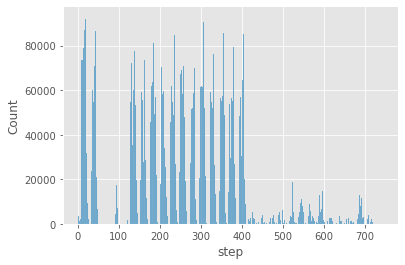

In [6]:
sns.histplot(data=df,x='step')

<AxesSubplot:xlabel='type', ylabel='count'>

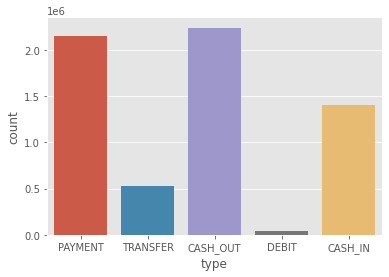

In [7]:
sns.countplot(data=df,x='type')

In [8]:
type = df.type.value_counts()
transaction = type.index
quantity = type.values

# draw pie chart with plotly
import plotly.express as px
figure = px.pie(df,
               values = quantity,
               names = transaction,
               hole = .5,
               title = 'Distribution of Transaction Type')
figure.show()

<AxesSubplot:>

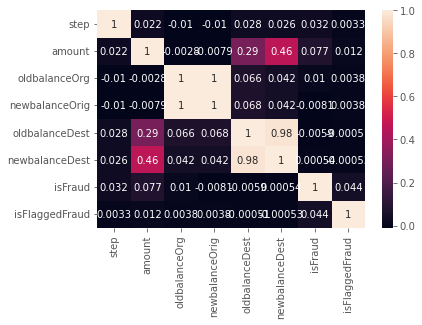

In [9]:
sns.heatmap(df.corr(), annot=True)

In [10]:
correlation = df.corr()
print(correlation['isFraud'].sort_values(ascending = False))

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64


## Preprocessing the data

Since the type column is categorical, we need to Label Encode it, so that it can be handled as a numerical value, instead of category

In [11]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
df['type'] = labelEncoder.fit_transform(df['type'])
print(df['type'].head())

0    3
1    3
2    4
3    1
4    3
Name: type, dtype: int32


The range of the Numerical columns in the dataset are not similar. This may cause problems, as the features with the larger value may dominate over the smaller valued ones. To avoid this, we normalize all the numerical columns using the Normalizer in sklearn.

In [12]:
# Importing the normalizing library
from sklearn.preprocessing import Normalizer

# Creating an instance of the normalizer
norm = Normalizer()
num_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Creating a deep copy of our dataframe so it may be modified without affecting the original
# For convenience, only the columns to be used in training our model will be kept
columns_to_keep = ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', \
                   'oldbalanceDest', 'newbalanceDest', 'isFraud']
# Replacing the numeric columns with their normalized values
df[num_columns] = norm.fit_transform(df[num_columns])
df = df[columns_to_keep]

In [13]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,3,0.042057,0.727196,0.685140,0.000000,0.0,0
1,3,0.064680,0.737225,0.672544,0.000000,0.0,0
2,4,0.707107,0.707107,0.000000,0.000000,0.0,1
3,1,0.008544,0.008544,0.000000,0.999927,0.0,1
4,3,0.222259,0.791534,0.569276,0.000000,0.0,0


## Data Splitting and Training the Models

In [14]:
from sklearn.model_selection import train_test_split
X = df.drop(labels="isFraud", axis = 1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [15]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [16]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

[13:03:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


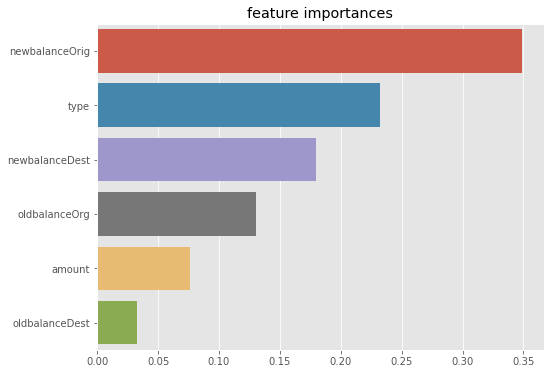

In [17]:
ftr_importances_values=xgb.feature_importances_
ftr_importances=pd.Series(ftr_importances_values,index=X_train.columns)
ftr_top20=ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title("feature importances")
sns.barplot(x=ftr_top20,y=ftr_top20.index)
plt.show()

In [18]:
rf_clf=RandomForestClassifier(random_state=0)
rf_clf.fit(X_train,y_train)
pred=rf_clf.predict(X_test)

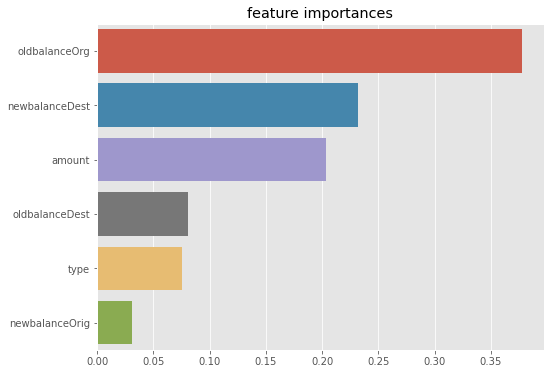

In [19]:
ftr_importances_values=rf_clf.feature_importances_
ftr_importances=pd.Series(ftr_importances_values,index=X_train.columns)
ftr_top20=ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title("feature importances")
sns.barplot(x=ftr_top20,y=ftr_top20.index)
plt.show()

# Model Evaluation
Before we can begin comparing our models, we need to determine how we will do so. Our models' accuracies alone will not make a good metric for comparison in this case for one simple reason:

In [20]:
df['isFraud'].sum() / len(df)

0.001290820448180152

Approximately 0.1% of our data observations are in fact instances of fraud. That means that if our model were to **never** predict a payment to be fraud, it would still be nearly 99.9% accurate. The metric we use for comparison must take this into account which leaves us with three options: Precision, Recall, and F1 score.

**Precision**: Would measure how many of the payments the model identifies as fraud are actually fraudulent

**Recall**: Would measure how many of the actual fraudulent payments the model identified as fraud

**F1 Score**: A combination of the two

In reality, this would be a decision to be made by the stakeholders based on what they feel is more important in the model's predictions. For the sake of this exercise, we will be using recall as one could reasonably argue that correctly identifying cases of fraud is more important than sounding a 'false alarm'.

With the metric of comparison chosen, we will proceed to make predictions with our models and score them.

In [21]:
from sklearn.metrics import recall_score

xg_pred = xgb.predict(X_test)
rf_pred = rf_clf.predict(X_test)

print("Random Forest Recall :", recall_score(y_test, rf_pred))
print("XGBoost Recall :", recall_score(y_test, xg_pred))

Random Forest Recall : 0.903751233958539
XGBoost Recall : 0.8558736426456071


In [22]:
from sklearn.model_selection import cross_validate
xg_scores = cross_validate(xgb, X_test, y_test, scoring='recall_macro')
rf_scores = cross_validate(rf_clf, X_test, y_test, scoring='recall_macro')

[13:37:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [23]:
xg_scores

{'fit_time': array([64.2208457 , 65.01200271, 69.01146221, 66.05660248, 66.66736317]),
 'score_time': array([0.36821055, 0.35194898, 0.3495512 , 0.36707592, 0.36673212]),
 'test_score': array([0.9135472 , 0.94071556, 0.91108593, 0.91601161, 0.92731472])}

In [24]:
rf_scores

{'fit_time': array([221.32312894, 211.87995648, 214.44281459, 238.54311991,
        249.00823617]),
 'score_time': array([2.53773928, 2.46136785, 2.44942451, 3.01571417, 2.93596482]),
 'test_score': array([0.92589917, 0.94564911, 0.90861994, 0.91601634, 0.92977463])}

In [25]:
features = np.array([[4, 0.3, 0.7, 0.2, 0.4, 1]])
print(xgb.predict(features))
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, xgb.predict(X_test)))

[0]
0.9997705347796977


## Saving the model for later use

In [68]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle

In [69]:
modelOut1 = open('xgb_model.h5', 'wb')
modelOut2 = open('rf_model.h5', 'wb')
normalizerOut = open('normalizer.sav', 'wb')
labelEncoderOut = open('label_encoder.sav', 'wb')
columns_to_keepOut = open('columns_to_keep.sav', 'wb')
num_columnsOut = open('numerical_columns.sav', 'wb')
pickle.dump(xgb, modelOut1)
pickle.dump(rf_clf, modelOut2)
pickle.dump(norm, normalizerOut)
pickle.dump(labelEncoder, labelEncoderOut)
pickle.dump(columns_to_keep, columns_to_keepOut)
pickle.dump(num_columns, num_columnsOut)

## Testing

In [70]:
# Testing process
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle

xgb_saved = pickle.load(open('xgb_model.h5', 'rb'))
rf_saved = pickle.load(open('rf_model.h5', 'rb'))
norm_saved = pickle.load(open('normalizer.sav', 'rb'))
label_saved = pickle.load(open('label_encoder.sav', 'rb'))
cols_saved = pickle.load(open('columns_to_keep.sav', 'rb'))
numerical_columns = pickle.load(open('numerical_columns.sav', 'rb'))

In [71]:
newdf = pd.read_csv('newData.csv')
newdf

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,18.00,C840083671,18.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,671.64,C2033524545,15123.00,14451.36,M473053293,0.00,0.00,0,0
5,1,TRANSFER,215310.30,C1670993182,705.00,0.00,C1100439041,22425.00,0.00,0,0
6,1,CASH_OUT,154139.72,C1642679791,79563.03,0.00,C564160838,410433.04,1254956.07,0,0
7,1,CASH_OUT,82685.93,C855700733,0.00,0.00,C392292416,833216.44,3420103.09,0,0
8,1,CASH_OUT,83857.23,C247162961,0.00,0.00,C1297685781,215457.59,16997.22,0,0
9,1,CASH_OUT,99109.77,C1890266440,0.00,0.00,C1297685781,299314.82,16997.22,0,0


In [72]:
newdf = newdf[cols_saved]
newdf[numerical_columns] = norm_saved.transform(newdf[numerical_columns])
newdf['type'] = label_saved.transform(newdf['type'])
newdf

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,3,0.042057,0.727196,0.685140,0.000000,0.000000,0
1,3,0.064680,0.737225,0.672544,0.000000,0.000000,0
2,4,0.707107,0.707107,0.000000,0.000000,0.000000,1
3,1,0.000850,0.000850,0.000000,0.999999,0.000000,1
4,3,0.032092,0.722607,0.690514,0.000000,0.000000,0
5,4,0.994615,0.003257,0.000000,0.103591,0.000000,0
6,1,0.115745,0.059745,0.000000,0.308199,0.942362,0
7,1,0.023483,0.000000,0.000000,0.236635,0.971315,0
8,1,0.361726,0.000000,0.000000,0.929397,0.073319,0
9,1,0.313882,0.000000,0.000000,0.947935,0.053830,0


In [73]:
from sklearn.metrics import accuracy_score
accuracy_score(newdf['isFraud'], xgb_saved.predict(newdf.drop(columns=['isFraud'])))

0.9

In [74]:
accuracy_score(newdf['isFraud'], rf_saved.predict(newdf.drop(columns=['isFraud'])))

0.9

# Conclusion
Upon training and evaluating our classification model, we found that the XGBoost model performed the best by a narrow margin. Going forward, we would make efforts to further enhance this classification model. For example, we omitted the payment destination ID from our model. This column could provide significant insight if we were to perform additional analysis on it to create a new independent variable for payments going to destinations previously identified as fraudulent. Additionally, we would use loops to tune the parameters of each model we train to ensure it's performing optimally before making comparisons. This would, however, be an extremely computationally heavy task outside the scope of this project.